# Testing RF Fields on worst trajectory

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
from numpy import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def set_fontsize(ax, fs):
    """
    Small function to set font sizes for figures
    """
    ax.tick_params(axis='both', which='major', labelsize=fs)
    ax.tick_params(axis='both', which='minor', labelsize=fs)
    ax.xaxis.label.set_size(fs)
    ax.yaxis.label.set_size(fs)
    ax.title.set_size(fs)

In [4]:
%%time
from quantumoperators import *
from hamiltonianoperators import *

Jmax = 6      # max J value in Hamiltonian
I_Tl = 1/2    # I1 in Ramsey's notation
I_F = 1/2     # I2 in Ramsey's notation

HamiltonianJ6 = Hamiltonian(Jmax, I_Tl, I_F)

Wall time: 56.1 s


## Generating Trajectories and Interpolating Fields
Simple trajectory generating function, simply straight though the lens without any bending to make comparisons simpler

In [7]:
from scipy.interpolate import interp1d

x = np.linspace(-0.008, 0.008, int(np.sqrt(500)))
y = np.linspace(-0.013, 0.013, int(np.sqrt(500)))

def generateTrajectory(x,y):
    tmax = 0.9/200
    t = np.linspace(0,tmax,100)    
    intTrajX = interp1d(t, np.ones(len(t))*x, kind = 'linear')
    intTrajY = interp1d(t, np.ones(len(t))*y, kind = 'linear')
    intTrajZ = interp1d(t, -0.45+t*200, kind = 'linear')
    
    return intTrajX, intTrajY, intTrajZ, tmax

In [8]:
import itertools
interpolateTrajectories = []
for xi, yi in itertools.product(x,y):
    interpolateTrajectories.append((generateTrajectory(xi,yi)))

In [20]:
from fields import *
field_dir = 'D:/Adiabatic Transfer/propagation/fields/'
c, intfun = fit_potential_xyz(field_dir+'potentialQuadrupole.fld', 0.022, 0.019, 0, 0)
cP, intfunP = fit_potential_xyz(field_dir+'potentialElectrodes_offset_-1kV.fld', 0.022, 0.019, .45, 0)
funEx,funEy,funEz,funEmag = combine_quadrupole_plate(c,intfun,cP,intfunP)

C:\Users\Olivier\Documents\CeNTREX Olivier\notebooks\non-adiabatic transitions\propagation\fields.py:46: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  c = np.linalg.lstsq(vander, f)[0]


In [21]:
with open('interpolatePotential_homogeneous_offset_-1kV', 'wb') as wfp:
    pickle.dump((c, intfun, cP, intfunP), wfp)

In [24]:
traj = interpolateTrajectories[473]

Checking trajectory to verify it matches the trajectory found in `State Propagation Parallel Homogeneous Offset.ipynb`

In [23]:
def plot_trajectory(traj, t = None):
    if isinstance(t, type(None)):
        t = np.linspace(0,traj[-1],10000)
    fig, axs = plt.subplots(2, 2, figsize = (15,8))
    axs[0][0].plot(t, traj[0](t), lw = 3)
    axs[0][1].plot(t, traj[1](t), lw = 3)
    axs[1][0].plot(t, traj[2](t), lw = 3)

    for ax in axs.flat:
        ax.set_xlabel('time [s]')
        ax.ticklabel_format(axis = 'y', style='sci', scilimits = (4,-2))
    #     ax.label_outer()

    for ax, ylabel in zip(axs.flat, 'x,y,z'.split(',')):
        ax.set_ylabel(f'{ylabel} [m]')

    fig.delaxes(axs[1][1])

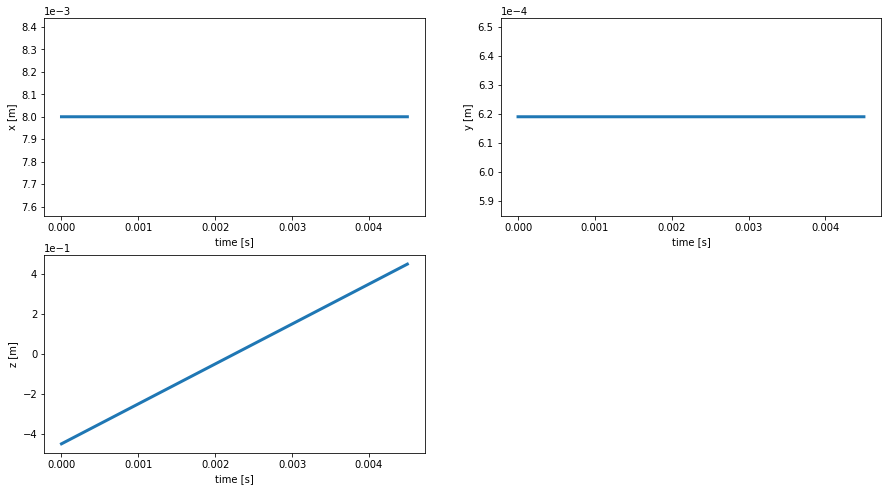

In [25]:
plot_trajectory(traj)

In [26]:
def plot_fields_trajectory(traj, funEx, funEy, funEz, funEmag, t = None):
    if isinstance(t, type(None)):
        t = np.linspace(0,traj[-1],10000)
    fig, axs = plt.subplots(2, 2, figsize = (15,8))
    axs[0][0].plot(t, funEx(traj[0](t), traj[1](t), traj[2](t)), lw = 3)
    axs[0][1].plot(t, funEy(traj[0](t), traj[1](t), traj[2](t)), lw = 3)
    axs[1][0].plot(t, funEz(traj[0](t), traj[1](t), traj[2](t)), lw = 3)
    axs[1][1].plot(t, funEmag(traj[0](t), traj[1](t), traj[2](t)), lw = 3)

    for ax in axs.flat:
        ax.set_xlabel('time [s]')
        ax.ticklabel_format(axis = 'y', style='sci', scilimits = (4,-2))
    #     ax.label_outer()

    for ax, ylabel in zip(axs.flat, 'Ex,Ey,Ez,|E|'.split(',')):
        ax.set_ylabel(f'{ylabel} [V/cm]')

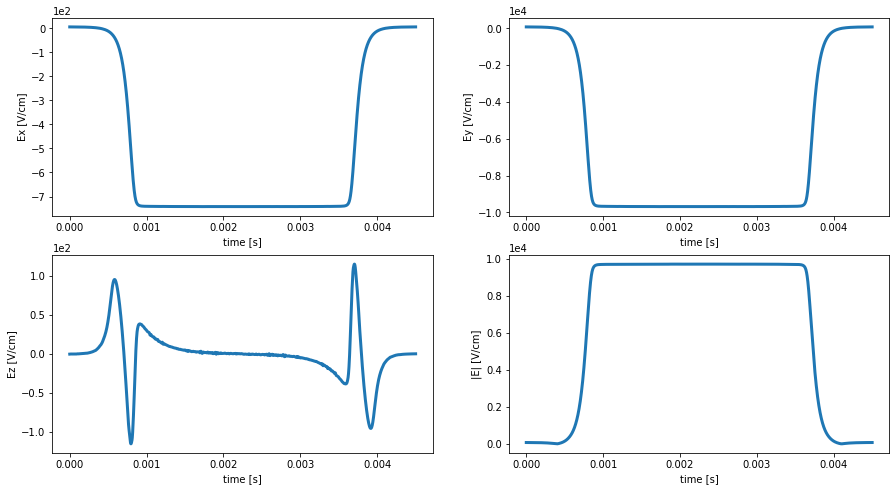

In [27]:
plot_fields_trajectory(traj, funEx, funEy, funEz, funEmag)

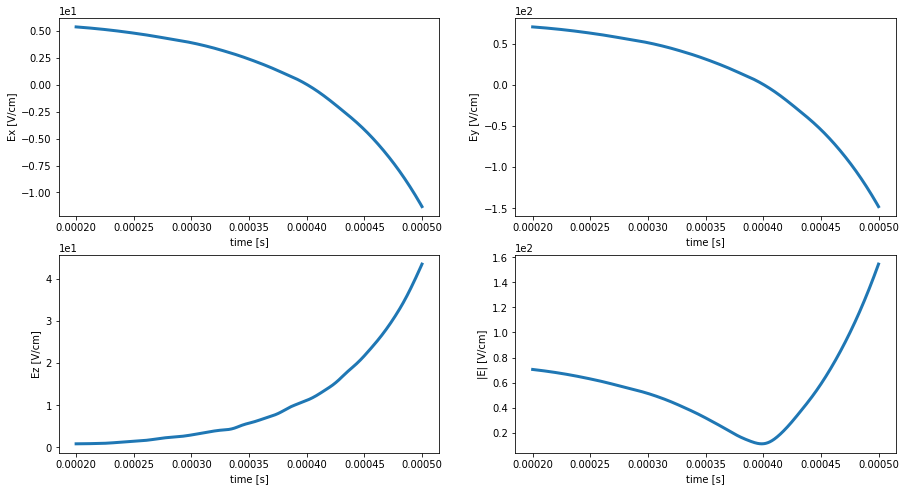

In [34]:
plot_fields_trajectory(traj, funEx, funEy, funEz, funEmag, t = np.linspace(0.0002,0.0005,1000))

## Convencience functions
For use in propagation

In [49]:
def Evec(x,y,z):
    """
    Return tuple with electric field values field
    """
    return funEx(x,y,z), funEy(x,y,z), funEz(x,y,z)

def get_coordinates(t, traj):
    """
    Return tuple with coordinates for a given trajectory
    """
    return traj[0](t), traj[1](t), traj[2](t)

Determining which range to set dt smaller for AC (and have AC active)

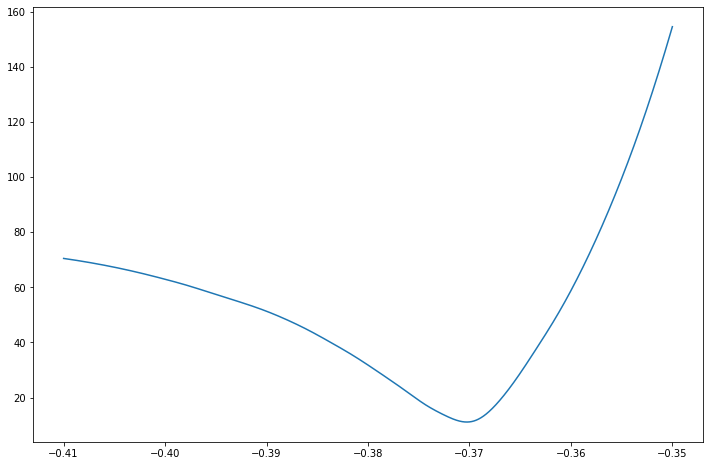

In [56]:
ti = np.linspace(0.0002,0.0005, 5000)
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(traj[2](ti), funEmag(*get_coordinates(ti, traj)))

## Propagation Function

In [95]:
from scipy.linalg import expm
from tqdm import tqdm_notebook as tqdm

def propagate(ham, traj, B, dt, acfreq, acamp):
    dt0, dt1 = dt
    B = list(B)
    fields = lambda t:  list(Evec(*get_coordinates(t, traj)))+B
    phi0 = np.linalg.eigh(ham.create_hamiltonian(*fields(0)))[1][:,35]
    phi = phi0.copy()
    pbar = tqdm(total = 0.9)
    ti = 0
    while ti <= traj[-1]:
        xi, yi, zi = get_coordinates(ti, traj)
        field = fields(ti)
        if (zi > -0.39) & (zi < -0.250):
            dt = dt0
            field[1] += acamp*np.sin(2*np.pi*ti*acfreq)
        elif (zi < 0.39) & (zi > 0.250):
            dt = dt0
            field[1] += acamp*np.sin(2*np.pi*ti*acfreq)
        else:
            dt = dt1
        phi = expm(-1j*dt*ham.create_hamiltonian(*field))@phi
        ti += dt
        pbar.update(dt*200)
    return phi0, phi

In [96]:
traj = interpolateTrajectories[473]

In [97]:
state_propagate = propagate(HamiltonianJ6, traj, [0,20,0], [5e-7,1e-6], 10e6, 0)

In [98]:
np.abs(state_propagate[-1].conj()@state_propagate[0])**2

0.12363378326146005

In [99]:
state_propagate = propagate(HamiltonianJ6, traj, [0,20,0], [5e-9,1e-6], 10e6, 400)

In [100]:
np.abs(state_propagate[-1].conj()@state_propagate[0])**2

0.28107404302004263

In [101]:
state_propagate = propagate(HamiltonianJ6, traj, [0,20,0], [5e-9,1e-6], 10e6, 700)

In [102]:
np.abs(state_propagate[-1].conj()@state_propagate[0])**2

0.021731507189053735

In [103]:
state_propagate = propagate(HamiltonianJ6, traj, [0,20,0], [5e-9,1e-6], 10e6, 1000)

In [104]:
np.abs(state_propagate[-1].conj()@state_propagate[0])**2

0.04399221704578348

In [105]:
state_propagate = propagate(HamiltonianJ6, traj, [0,20,0], [5e-9,1e-6], 10e6, 200)

In [106]:
np.abs(state_propagate[-1].conj()@state_propagate[0])**2

0.19171502964898762

In [118]:
state_propagate = propagate(HamiltonianJ6, traj, [0,20,0], [5e-9,1e-6], 10e6, 500)
np.abs(state_propagate[-1].conj()@state_propagate[0])**2

0.335953554326235

In [119]:
for amp in [300,350,450,550,600]:
    state_propagate = propagate(HamiltonianJ6, traj, [0,20,0], [5e-9,1e-6], 10e6, amp)
    p = np.abs(state_propagate[-1].conj()@state_propagate[0])**2
    print(f'ac ampliude : {amp}; p = {p}')

ac ampliude : 300; p = 0.20852938614684016


ac ampliude : 350; p = 0.0282205135596925


ac ampliude : 450; p = 0.1440584223494594


ac ampliude : 550; p = 0.2087508161834188


ac ampliude : 600; p = 0.015191231295931381


In [116]:
def set_fontsize(ax, fs):
    """
    Small function to set font sizes for figures
    """
    ax.tick_params(axis='both', which='major', labelsize=fs)
    ax.tick_params(axis='both', which='minor', labelsize=fs)
    ax.xaxis.label.set_size(fs)
    ax.yaxis.label.set_size(fs)
    ax.title.set_size(fs)

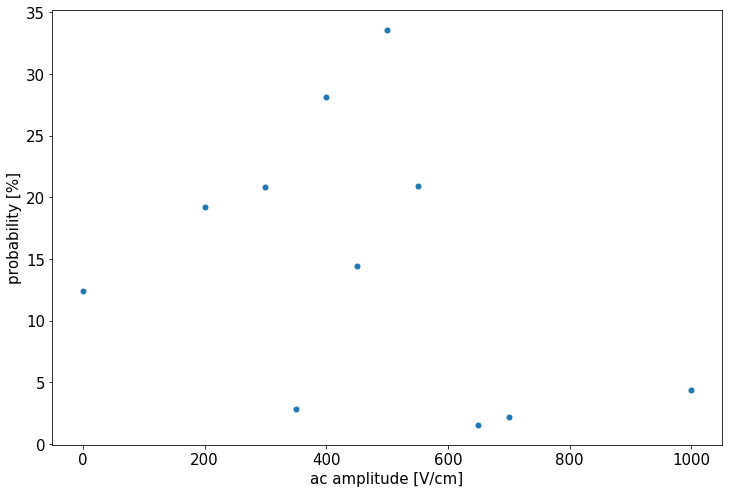

In [120]:
ac_amp = [0,200,400,700,1000,500,300,350,450,550,650]
prob = [0.12363378326146005, 0.19171502964898762, 0.28107404302004263, 0.021731507189053735, 0.04399221704578348,
        0.335953554326235, 0.20852938614684016, 0.0282205135596925, 0.1440584223494594, 0.2087508161834188, 0.015191231295931381]

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(ac_amp, [p*100 for p in prob], '.', ms = 10)
ax.set_xlabel('ac amplitude [V/cm]')
ax.set_ylabel('probability [%]');
set_fontsize(ax, 15)